In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [6]:
device = "cpu" # "cuda" si gpu

In [ ]:
# chargement des données
fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]

In [ ]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire
# <SOS> et <EOS> sont ajoutés respectivement au début et à la fin de chaque séquence
# <pad> est utilisé pour faire en sorte que toutes les séquences aient la même longueur

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [7]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # <SOS> et <EOS>

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

def get_batch(split, batch_size):
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(low=int(batch_size/2), high=int(data.shape[0]-batch_size/2), size=(1,), dtype=torch.int32).item()

    batch = data[int(idx_seed-batch_size/2):int(idx_seed+batch_size/2)]
    X = batch[:, :-1].to(device) # (B, L=max_len-1=46)
    Y = batch[:, 1:].to(device) # (B, L)
    return X, Y.long()

In [81]:
class BengioMLP(nn.Module):
    def __init__(self, d_model, d_hidden, n_context, vocabulaire):
        super().__init__()

        self.vocabulaire = vocabulaire
        self.n_context = n_context

        self.embed = nn.Embedding(len(vocabulaire), d_model)
        self.fc1 = nn.Linear(n_context * d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, len(vocabulaire))

    def forward(self, idx):
        embeddings = []
        # on ajoute autant de <SOS> que nécessaire avant le début de la séquence (un seul <SOS> est déjà présent)
        for _ in range(self.n_context):
            embd = self.embed(idx)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = char_to_int['<SOS>']
            embeddings.append(embd)

        embeddings = torch.cat(embeddings, -1) # (B, L, n_context*d_model)

        x = F.tanh(self.fc1(embeddings)) # (B, L, d_hidden)
        logits = self.fc2(x) # (B, L, vocab_size)

        return logits
    
    def sample(self, prompt = "", g = torch.Generator(), device="cpu"):
        idx = torch.tensor([char_to_int[c] for c in prompt], dtype=torch.int32, device=device).unsqueeze(0)
        idx = torch.cat([torch.tensor(char_to_int['<SOS>'], device=device).view(1, 1), idx], dim=1)
        next_id = -1

        while next_id != char_to_int['<EOS>']:
            idx_cond = idx if idx.size(1) <= self.n_context else idx[:, -self.n_context:]
            logits = self.forward(idx_cond) # (1, l, vocab_size)
            probs = F.softmax(logits[:, -1, :], dim=-1)
            next_id = torch.multinomial(probs, num_samples=1, generator=g).item()
            idx = torch.cat([idx, torch.tensor(next_id, device=device).view(1, 1)], dim=1)
        
        return "".join([int_to_char[p.item()] for p in idx[0, 1:-1]])

In [82]:
d_model = 8 # dimension du plongement de chaque lettre
d_hidden = 128 # nombre de neurones dans la couche cachée
n_context = 10 # taille du contexte

lr = 3e-4
batch_size = 64

model = BengioMLP(d_model=d_model, d_hidden=d_hidden, n_context=n_context, vocabulaire=vocabulaire).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)

print(f"Nombre de paramètres : {sum(p.numel() for p in model.parameters())}")

Nombre de paramètres : 16670


In [32]:
for i in range(20000):
    X, Y = get_batch('train', batch_size) # (B, L)
    logits = model(X) # (B, L, vocab_size)

    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=char_to_int['<pad>'])
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i%1000==0:
        X, Y = get_batch('val', batch_size) # (B, L)
        logits = model(X) # (B, L, vocab_size)
        val_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=char_to_int['<pad>'])

        print(f"train loss : {loss.item():.2f} | val loss : {val_loss.item():.2f}")

train loss : 3.86 | val loss : 3.85


train loss : 2.37 | val loss : 2.29
train loss : 2.11 | val loss : 2.18
train loss : 2.10 | val loss : 2.01
train loss : 1.88 | val loss : 2.04
train loss : 1.95 | val loss : 1.93
train loss : 1.88 | val loss : 2.01
train loss : 1.80 | val loss : 1.96
train loss : 1.85 | val loss : 1.96
train loss : 1.92 | val loss : 1.77
train loss : 1.95 | val loss : 1.81
train loss : 1.84 | val loss : 1.87
train loss : 1.88 | val loss : 1.79
train loss : 1.73 | val loss : 1.90
train loss : 1.82 | val loss : 1.75
train loss : 1.82 | val loss : 1.76
train loss : 1.81 | val loss : 1.81
train loss : 1.84 | val loss : 1.81
train loss : 1.77 | val loss : 1.82
train loss : 1.81 | val loss : 1.86


In [84]:
X = X_train[:, :-1].to(device) # (B, L=max_len-1=46)
Y = X_train[:, 1:].long().to(device) # (B, L)

logits = model(X) # (B, L, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=char_to_int['<pad>'])
print(f"total train loss : {loss.item():.2f}")

X = X_val[:, :-1].to(device) # (B, L=max_len-1=46)
Y = X_val[:, 1:].long().to(device) # (B, L)

logits = model(X) # (B, L, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=char_to_int['<pad>'])
print(f"total val loss   : {loss.item():.2f}")

total train loss : 1.77
total val loss   : 1.81


In [68]:
torch.save(model.state_dict(), f"mlp_d_model{d_model}_d_hidden{d_hidden}_n_context{n_context}.pth")

## génération

In [83]:
model.load_state_dict(torch.load(f"mlp_d_model{d_model}_d_hidden{d_hidden}_n_context{n_context}.pth")))

<All keys matched successfully>

In [92]:
g = torch.Generator(device).manual_seed(123456789+3)

for _ in range(10):
    print(model.sample(g=g, device=device))

vont-sivois
ernéhac-bes-mont
larat
corrhièche
breslans
pouilly-ses-grargfers
tontren
thuercel
guizerzes
bouville-flevelie


## visualisation des embeddings

In [42]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [59]:
embeddings = model.embed.weight.detach().cpu().numpy()

# TSNE
#tsne = TSNE(n_components=2, random_state=42)
#embeddings_2d = tsne.fit_transform(embeddings)

# PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

labels = [int_to_char[i] for i in range(len(embeddings))]

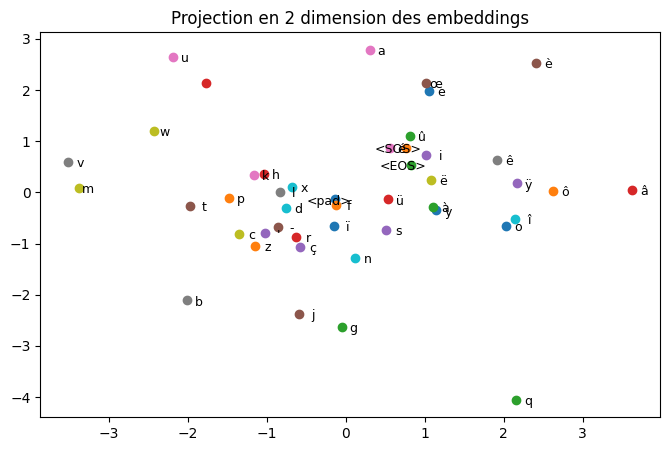

In [67]:
plt.figure(figsize=(8, 5))
for i, label in enumerate(labels):
    x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
    plt.scatter(x, y)
    plt.text(x+0.2, y-0.1, label, fontsize=9, ha='right')

plt.title('Projection en 2 dimensions des embeddings')
plt.savefig('viz_embeddings.png', dpi=600)